# First blood

First mini-experiment to see what we do and do not detect as anomalies in our artificial data.

## Preliminaries

In [1]:
# Basic imports
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys


from inspect import signature
from os.path import dirname
from sklearn.tree import *
from sklearn import datasets 
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split



In [2]:
note_dir = os.getcwd()
root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, 'src')

sys.path.extend([src_dir])

In [3]:
import mercs
from mercs.core import MERCS

In [4]:
def filter_config(function, config):
    
    sign = signature(function)
    relevant_parameters = set(sign.parameters.keys())
    
    filtered_cfg = {k:v for k,v in config.items()
                    if k in relevant_parameters}
    
    return filtered_cfg

## Datasets

In [5]:
np.random.seed(16)
n_samples = 1500

In [6]:
data = datasets.make_moons(n_samples=n_samples, noise=.05)

In [7]:
anomalies = np.random.rand(n_samples, 2)

In [8]:
X = data[0]
y = data[1] # y are cluster labels

In [9]:
x_range = np.min(X[:, 0]), np.max(X[:, 0])
y_range = np.min(X[:, 1]), np.max(X[:, 1])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Fit

### Fit MERCS

In [11]:
model = MERCS()

In [12]:
ind_parameters = {'ind_type':                   'DT',
                  'ind_min_samples_leaf':       30,
                  'ind_marginal_kdes':          True,
                  'ind_joint_kdes':             True}

sel_parameters = {'sel_type':           'Random',
                  'sel_its':            10,
                  'sel_param':          1}


In [13]:
model.fit(X_train, **ind_parameters, **sel_parameters)

### Fit anomaly Detector

In [14]:
model.fit_scores_scaler(X_train, scaler_kind='Robust')

## Test

In [15]:
plot_data = np.random.rand(n_samples, 2)*3-1
scores = model.score_samples(plot_data, kde_kind='marginal', aggregation='mean')

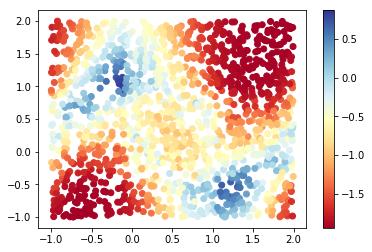

In [16]:
# Plot the results
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(plot_data[:, 0], plot_data[:, 1], c=scores, cmap=cm)
plt.colorbar(sc)
plt.show()

In [17]:
plot_step = 0.01
x_min, x_max = x_range
y_min, y_max = y_range

xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)) # Make grid.
grid_data = np.c_[xx.ravel(), yy.ravel()]

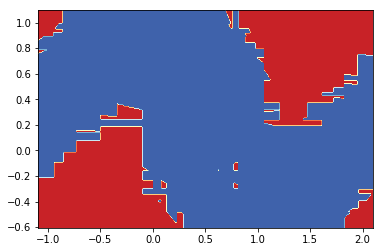

In [18]:
scores = model.score_samples(grid_data, kde_kind='marginal', aggregation='mean')
scores = scores.reshape(xx.shape)
scores = scores > -1
cs = plt.contourf(xx, yy, scores, cmap=cm)
plt.show()

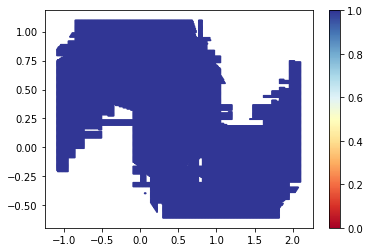

In [19]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(xx, yy, scores, c=scores, cmap=cm)
plt.colorbar(sc)
plt.show()

## Workflow

Elementary experiment.

### Dataset-generation

We are looking at some basic datasets from sklearn.

In [20]:
from inspect import signature

def extract_kwargs(f):
    sign = signature(f)
    kwargs = tuple(sign.parameters.keys())
    return kwargs

In [21]:
def dataset(dataset_name="moons", 
            dataset_kwargs=None):
    
    t = None
    
    if dataset_kwargs is None:
        dataset_kwargs = {}
    
    if dataset_name in {"moons"}:
        f = datasets.make_moons
    elif dataset_name in {"circles"}:
        f = datasets.make_circles
    elif dataset_name in {"blobs"}:
        f = datasets.make_blobs
    elif dataset_name in {"ablobs"}:
        
        f = datasets.make_blobs

        def t(data, transformation=None):
            
            X, Y = data[0], data[1]
            
            if transformation is None:
                transformation = [[0.6, -0.4],
                                  [-0.1, 0.8]]
            else:
                assert transformation.shape == (2,2)
            
            X_aniso = np.dot(X, transformation)
            return X_aniso, Y    
        
    else:
        msg = """
        I am not prepared to generate this dataset.
        """
        raise ValueError(msg)
        
    
    
    dataset_kwargs = filter_config(f, dataset_kwargs) # Make it a bit robust to irrelevant settings
    data = f(**dataset_kwargs)
    
    if t is not None:
        transformation_kwargs = filter_config(t, dataset_kwargs)
        data = t(data, **transformation_kwargs)
    
    X = data[0]
    Y = data[1] # y are cluster labels
    
    return X, Y

#### Demo

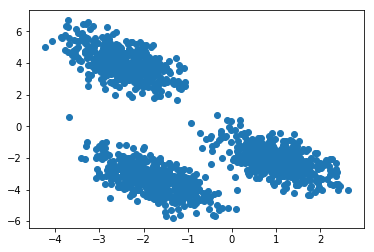

In [22]:
cfg = {"dataset_name":         "ablobs", 
       "dataset_kwargs":  {"n_samples":    1500,
                           "random_state": 60,
                           #"cluster_std": [.2, .5, 1.0],
                           "noise":0.05}}

X, Y = dataset(**cfg)

plt.scatter(X[:, 0], X[:, 1])

### Fit Mercs

Fitting our MERCS model initially.

In [23]:
def fit_mercs(X_train, ind_kwargs=None, sel_kwargs=None):
    
    if ind_kwargs is None:
        ind_kwargs = {}
    if sel_kwargs is None:
        sel_kwargs = {}
    
    model = MERCS(**ind_kwargs, **sel_kwargs)
    model.fit(X_train)
    return model

#### Demo

In [24]:
ind_parameters = {'ind_type':                   'DT',
                  'ind_min_samples_leaf':       30,
                  'ind_marginal_kdes':          True,
                  'ind_joint_kdes':             True}

sel_parameters = {'sel_type':           'Random',
                  'sel_its':            10,
                  'sel_param':          1}

cfg = {"ind_kwargs": ind_parameters,
       "sel_kwargs": sel_parameters}

model = fit_mercs(X, **cfg)

### Fit Detector

Second step, we need to fit the distributions in the leaves.

In [25]:
def fit_detector(model, X_train, scaler_kind="Robust", scaler_kwargs=None):
    
    if scaler_kwargs is None:
        scaler_kwargs = {}
    
    model.fit_scores_scaler(X_train, scaler_kind=scaler_kind, **scaler_kwargs)
    return model

#### Demo

In [26]:
cfg = {"scaler_kind":    "Robust"}

model = fit_detector(model, X, **cfg)

### Score Detector

Fit the detector **on a grid** so we can get a view of what this means.

In [27]:
def make_grid(X):
    
    x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
    y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    x_plot_step = (x_range/50)
    y_plot_step = (y_range/50)
    
    x_pts = np.arange(x_min, x_max, x_plot_step)
    y_pts = np.arange(y_min, y_max, y_plot_step)
    
    if x_pts.size * y_pts.size > 10**5:
        msg = """
        This grid is too damn big son.
        """
        raise ValueError(msg)

    xx, yy = np.meshgrid(x_pts, y_pts) # Make grid.
    grid_data = np.c_[xx.ravel(), yy.ravel()]

    
    return grid_data

def score_grid(model, grid_data, kde_kind='marginal', aggregation='mean', threshold=-1):
    scores = model.score_samples(grid_data, kde_kind=kde_kind, aggregation= aggregation)
    
    #scores = scores.reshape(grid_data.shape[0])
    
    if threshold is not None:
        scores = scores > threshold
    return scores

#### Demo

In [28]:
grid_data = make_grid(X)

In [29]:
cfg_score_grid = {"kde_kind":       'marginal', 
                   "aggregation":    'mean',
                   "threshold":      -1}

scores = score_grid(model, grid_data, **cfg_score_grid)

In [30]:
grid_data

array([[-4.24279882, -5.78318558],
       [-4.10531907, -5.78318558],
       [-3.96783933, -5.78318558],
       ...,
       [ 2.21874902,  6.44240077],
       [ 2.35622876,  6.44240077],
       [ 2.4937085 ,  6.44240077]])

In [31]:
150*300

45000

### Plot

In [32]:
def plot_scores(grid_data, scores, ax=None):
    cm = plt.cm.get_cmap('RdYlBu')
    if ax is None:
        sc = plt.scatter(grid_data[:, 0], grid_data[:, 1], scores, c=scores, cmap=cm)
    else:
        print(grid_data.shape[0])
        ax.scatter(grid_data[:, 0], grid_data[:, 1], scores, c=scores, cmap=cm)

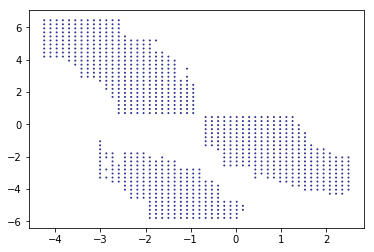

In [33]:
sc = plot_scores(grid_data, scores)
plt.show()

## Bringing it all back home

In [34]:
def build_config(dataset_name="moons",
                 ind_min_samples_leaf=30,
                 scaler_kind="Robust",
                 aggregation='mean',
                 threshold=-1.5):
    
    # Configuration
    cfg_dataset = {"dataset_name":         dataset_name, 
                   "dataset_kwargs":  {"n_samples":    1500,
                                       "random_state": 60,
                                       "factor":       0.5,
                                       "noise":        0.02}}
    
    ind_parameters = {'ind_type':                   'DT',
                      'ind_min_samples_leaf':       ind_min_samples_leaf,
                      'ind_marginal_kdes':          True,
                      'ind_joint_kdes':             True}
    

    sel_parameters = {'sel_type':           'Random',
                      'sel_its':            30,
                      'sel_param':          1}

    cfg_fit_mercs = {"ind_kwargs": ind_parameters,
                     "sel_kwargs": sel_parameters}
    
    cfg_fit_detector = {"scaler_kind":    scaler_kind}
    
    cfg_score_grid = {"kde_kind":       'marginal', 
                      "aggregation":    aggregation,
                      "threshold":      threshold}
    
    cfg = {**cfg_dataset,
           **cfg_fit_mercs,
           **cfg_fit_detector,
           **cfg_score_grid}
    
    return cfg

def workflow(config):
    
    # Splitting up config
    cfg_dataset = filter_config(dataset, config)
    cfg_fit_mercs = filter_config(fit_mercs, config)
    cfg_fit_detector = filter_config(fit_detector, config)
    cfg_score_grid = filter_config(score_grid, config)
    
    # Actions
    X, Y = dataset(**cfg_dataset)
    
    model = fit_mercs(X, **cfg_fit_mercs)
    
    model = fit_detector(model, X, **cfg_fit_detector)
    
    grid_data = make_grid(X)
    
    scores = score_grid(model, grid_data, **cfg_score_grid)
    
    return grid_data, scores

In [35]:
manual_cfg = {"dataset_name":          "moons", 
              "ind_min_samples_leaf":  20,
              "scaler_kind":          "Robust",
              "aggregation":          "mean",
              "threshold":            -0.7}

cfg = build_config(**manual_cfg)

plot = workflow(cfg)
plt.show()

In [36]:
manual_cfg = {"dataset_name":          "moons", 
               "ind_min_samples_leaf":  40,
               "scaler_kind":          "Robust",
               "aggregation":          "mean",
               "threshold":            -1}

cfg = build_config(**manual_cfg)

plot = workflow(cfg)
plt.show()

In [37]:
manual_cfg = {"dataset_name":          "moons",
              "ind_min_samples_leaf":  40,
              "scaler_kind":          "Robust",
              "aggregation":          "mean",
              "threshold":            -0.7}

cfg = build_config(**manual_cfg)

plot = workflow(cfg)
plt.show()

2500
2550
2500
2500
2500
2550
2500
2500
2500
2550
2500
2500
2500
2550
2500
2500
2500
2550
2500
2500


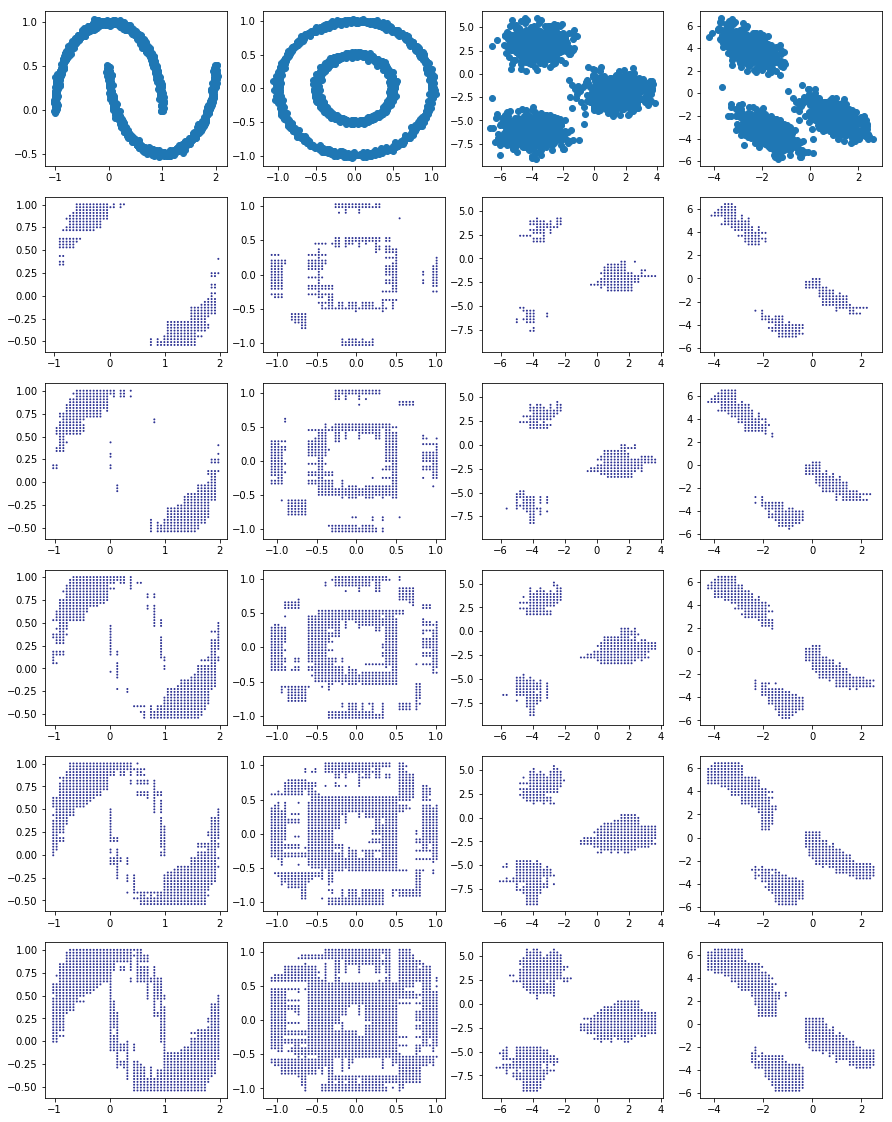

In [40]:




manual_cfg = {"dataset_name":          "moons",
              "ind_min_samples_leaf":  40,
              "scaler_kind":          "StandardScaler",
              "aggregation":          "mean",
              "threshold":            -0.6}

x_param = "dataset_name"
x_param_range = ["moons", "circles", "blobs", "ablobs"] 

y_param = "threshold"
y_param_range = [0, -0.2, -0.4, -0.6, -0.8]

# Do the plot
fig, ax = plt.subplots(nrows=len(y_param_range)+1, ncols=len(x_param_range), figsize=(15,20))

for r, row in list(enumerate(ax))[:1]:

    for c, col in enumerate(row):
        
        manual_cfg = {**manual_cfg, **{x_param: x_param_range[c]}} # Adapt config
        cfg = build_config(**manual_cfg)
        cfg_dataset = filter_config(dataset, cfg)
        X, _ = dataset(**cfg_dataset)
        col.scatter(X[:, 0], X[:, 1])
    

for r, row in list(enumerate(ax))[1:]:
    
    manual_cfg = {**manual_cfg, **{y_param: y_param_range[r-1]}} # Adapt config
    
    for c, col in enumerate(row):
        manual_cfg = {**manual_cfg, **{x_param: x_param_range[c]}} # Adapt config
        
        cfg = build_config(**manual_cfg)
        
        grid_data, scores = workflow(cfg)
        
        plot_scores(grid_data, scores, ax=col)

In [39]:
plt.show()